In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, confusion_matrix
from scipy.cluster.hierarchy import dendrogram, linkage

In [4]:
# Download dataset if not already
!wget -nc https://archive.ics.uci.edu/static/public/240/human+activity+recognition+using+smartphones.zip -O har_dataset.zip

# Unzip main archive
!unzip -n har_dataset.zip -d har_dataset

# Unzip the inner archive (UCI HAR Dataset.zip inside)
!unzip -n "har_dataset/UCI HAR Dataset.zip" -d har_dataset/

# Now load the data
X_train = pd.read_csv("har_dataset/UCI HAR Dataset/train/X_train.txt", sep='\s+', header=None)
y_train = pd.read_csv("har_dataset/UCI HAR Dataset/train/y_train.txt", header=None)

X_test = pd.read_csv("har_dataset/UCI HAR Dataset/test/X_test.txt", sep='\s+', header=None)
y_test = pd.read_csv("har_dataset/UCI HAR Dataset/test/y_test.txt", header=None)

# Combine train + test
X = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)
y = pd.concat([y_train, y_test], axis=0).reset_index(drop=True)

print("Dataset Shape:", X.shape, "Labels:", y.shape)


File ‘har_dataset.zip’ already there; not retrieving.


<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-641356738.py:11: SyntaxWarning: invalid escape sequence '\s'
  X_train = pd.read_csv("har_dataset/UCI HAR Dataset/train/X_train.txt", sep='\s+', header=None)
/tmp/ipython-input-641356738.py:14: SyntaxWarning: invalid escape sequence '\s'
  X_test = pd.read_csv("har_dataset/UCI HAR Dataset/test/X_test.txt", sep='\s+', header=None)


Archive:  har_dataset.zip
Archive:  har_dataset/UCI HAR Dataset.zip
   creating: har_dataset/UCI HAR Dataset/
  inflating: har_dataset/UCI HAR Dataset/.DS_Store  
   creating: har_dataset/__MACOSX/
   creating: har_dataset/__MACOSX/UCI HAR Dataset/
  inflating: har_dataset/__MACOSX/UCI HAR Dataset/._.DS_Store  
  inflating: har_dataset/UCI HAR Dataset/activity_labels.txt  
  inflating: har_dataset/__MACOSX/UCI HAR Dataset/._activity_labels.txt  
  inflating: har_dataset/UCI HAR Dataset/features.txt  
  inflating: har_dataset/__MACOSX/UCI HAR Dataset/._features.txt  
  inflating: har_dataset/UCI HAR Dataset/features_info.txt  
  inflating: har_dataset/__MACOSX/UCI HAR Dataset/._features_info.txt  
  inflating: har_dataset/UCI HAR Dataset/README.txt  
  inflating: har_dataset/__MACOSX/UCI HAR Dataset/._README.txt  
   creating: har_dataset/UCI HAR Dataset/test/
   creating: har_dataset/UCI HAR Dataset/test/Inertial Signals/
  inflating: har_dataset/UCI HAR Dataset/test/Inertial Signals/b

In [18]:
# Check for missing values
print("Missing values:", X.isnull().sum().sum())

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encode labels (activities: 1–6)
activity_map = {
    1: "WALKING",
    2: "WALKING_UPSTAIRS",
    3: "WALKING_DOWNSTAIRS",
    4: "SITTING",
    5: "STANDING",
    6: "LAYING"
}
y_labels = y[0].map(activity_map)
y_true = y[0].values.ravel()


Missing values: 0


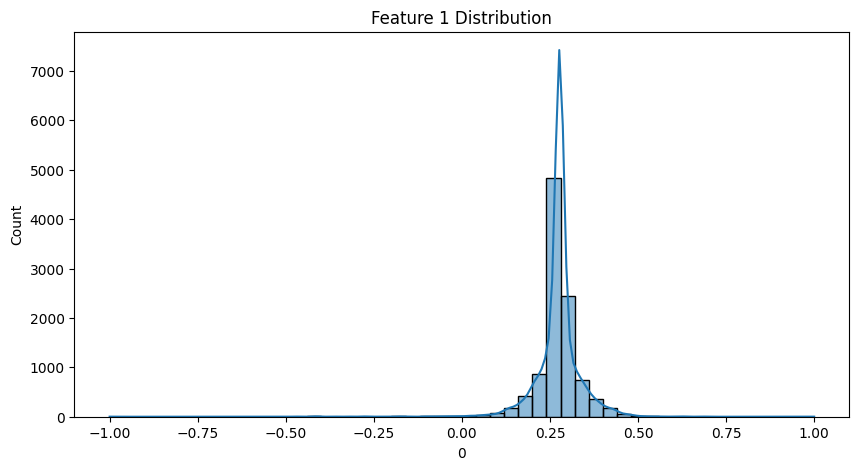

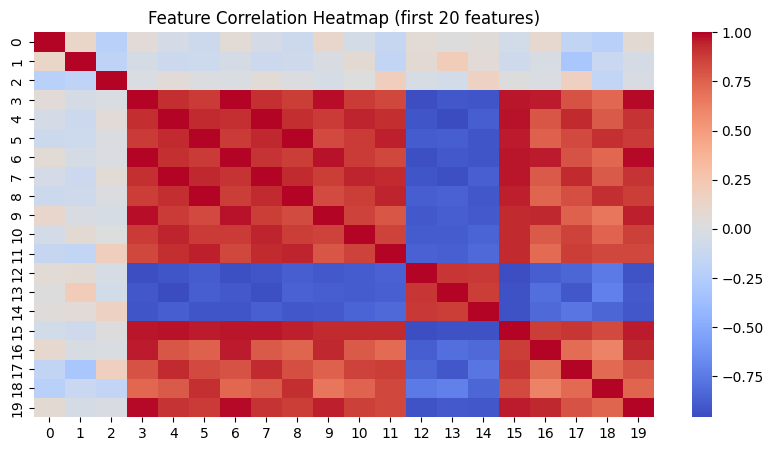

In [19]:
plt.figure(figsize=(10,5))
sns.histplot(X.iloc[:,0], bins=50, kde=True)
plt.title("Feature 1 Distribution")
plt.show()

plt.figure(figsize=(10,5))
sns.heatmap(pd.DataFrame(X_scaled).iloc[:500,:20].corr(), cmap="coolwarm")
plt.title("Feature Correlation Heatmap (first 20 features)")
plt.show()

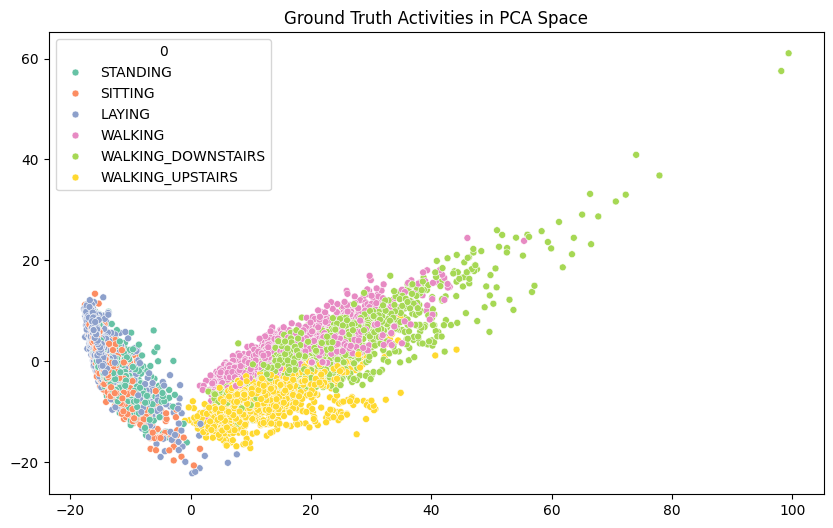

In [20]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(10,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y_labels, s=25, palette="Set2")
plt.title("Ground Truth Activities in PCA Space")
plt.show()

In [21]:
# Basic stats
print("Number of features:", X.shape[1])
print("Number of activities:", y[0].nunique())
print(y[0].value_counts())


Number of features: 561
Number of activities: 6
0
6    1944
5    1906
4    1777
1    1722
2    1544
3    1406
Name: count, dtype: int64


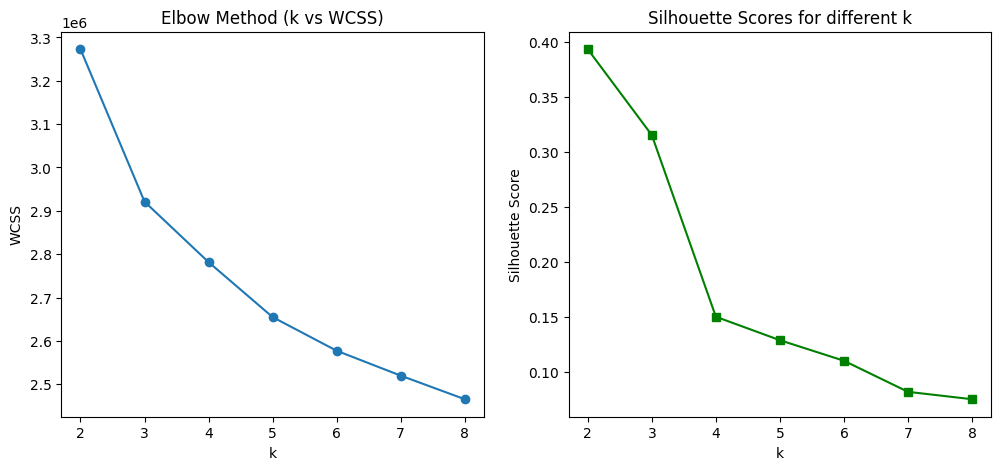

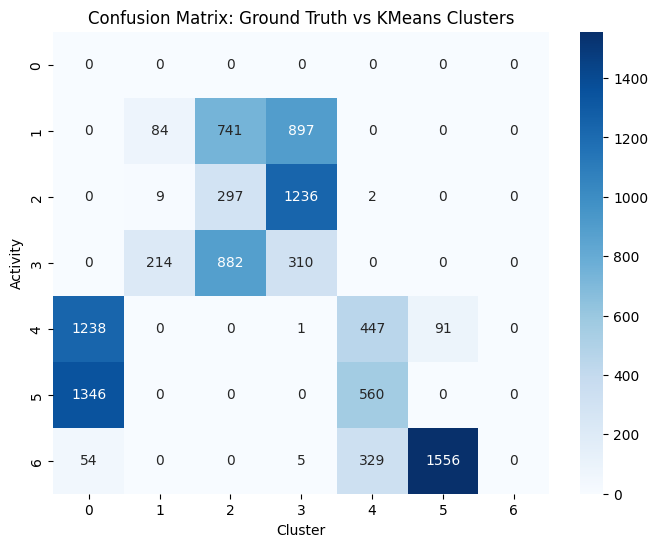

In [22]:
wcss = []
sil_scores = []
K_range = range(2,9)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    wcss.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(K_range, wcss, marker='o')
plt.title("Elbow Method (k vs WCSS)")
plt.xlabel("k"); plt.ylabel("WCSS")

plt.subplot(1,2,2)
plt.plot(K_range, sil_scores, marker='s', color='green')
plt.title("Silhouette Scores for different k")
plt.xlabel("k"); plt.ylabel("Silhouette Score")
plt.show()

best_k = 6  # Assume from elbow
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

# ------------------- DBSCAN -------------------
dbscan = DBSCAN(eps=1.5, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_scaled)

# ------------------- HAC -------------------
pca_hac = PCA(n_components=50, random_state=42)
X_reduced_hac = pca_hac.fit_transform(X_scaled)
hac = AgglomerativeClustering(n_clusters=6, linkage='ward')
hac_labels = hac.fit_predict(X_reduced_hac)

# ------------------- Confusion Matrix Example -------------------
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_true, kmeans_labels)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix: Ground Truth vs KMeans Clusters")
plt.xlabel("Cluster"); plt.ylabel("Activity")
plt.show()

     Algo  Silhouette       DBI          CHI       ARI       NMI
0  KMeans    0.109895  2.383567  2556.541948  0.419620  0.559326
1     HAC    0.129356  2.064510  3292.688217  0.421752  0.579220


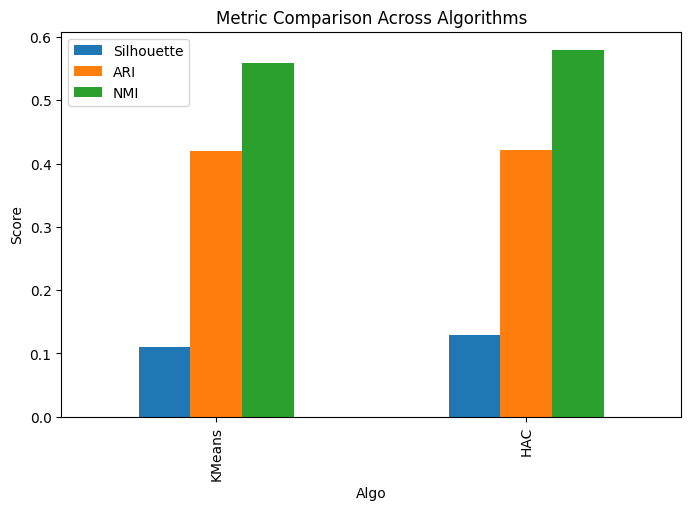

In [23]:
# ------------------- Metric Comparison -------------------
def evaluate(name, labels, X_eval):
    return {
        "Algo": name,
        "Silhouette": silhouette_score(X_eval, labels),
        "DBI": davies_bouldin_score(X_eval, labels),
        "CHI": calinski_harabasz_score(X_eval, labels),
        "ARI": adjusted_rand_score(y_true, labels),
        "NMI": normalized_mutual_info_score(y_true, labels)
    }

results = []
results.append(evaluate("KMeans", kmeans_labels, X_scaled))
results.append(evaluate("DBSCAN", dbscan_labels, X_scaled) if len(set(dbscan_labels))>1 else None)
results.append(evaluate("HAC", hac_labels, X_reduced_hac))

results = [r for r in results if r]
df_results = pd.DataFrame(results)
print(df_results)

# Bar plot of metrics
df_results.set_index("Algo")[["Silhouette","ARI","NMI"]].plot(kind="bar", figsize=(8,5))
plt.title("Metric Comparison Across Algorithms")
plt.ylabel("Score")
plt.show()


=== K-Means Results Table (k, WCSS, Silhouette) ===
k    WCSS           Silhouette     
2    3272856.62     0.3937         
3    2921077.60     0.3155         
4    2781602.14     0.1500         
5    2654789.79     0.1286         
6    2577180.43     0.1099         
7    2519774.22     0.0816         
8    2465378.96     0.0749         

=== DBSCAN Parameter Tuning ===
eps=0.5, min_samples=5 -> Clusters=0, Noise=10299
eps=0.5, min_samples=10 -> Clusters=0, Noise=10299
eps=0.5, min_samples=20 -> Clusters=0, Noise=10299
eps=1.0, min_samples=5 -> Clusters=0, Noise=10299
eps=1.0, min_samples=10 -> Clusters=0, Noise=10299
eps=1.0, min_samples=20 -> Clusters=0, Noise=10299
eps=1.5, min_samples=5 -> Clusters=0, Noise=10299
eps=1.5, min_samples=10 -> Clusters=0, Noise=10299
eps=1.5, min_samples=20 -> Clusters=0, Noise=10299
eps=2.0, min_samples=5 -> Clusters=0, Noise=10299
eps=2.0, min_samples=10 -> Clusters=0, Noise=10299
eps=2.0, min_samples=20 -> Clusters=0, Noise=10299
eps=3.0, min_sampl

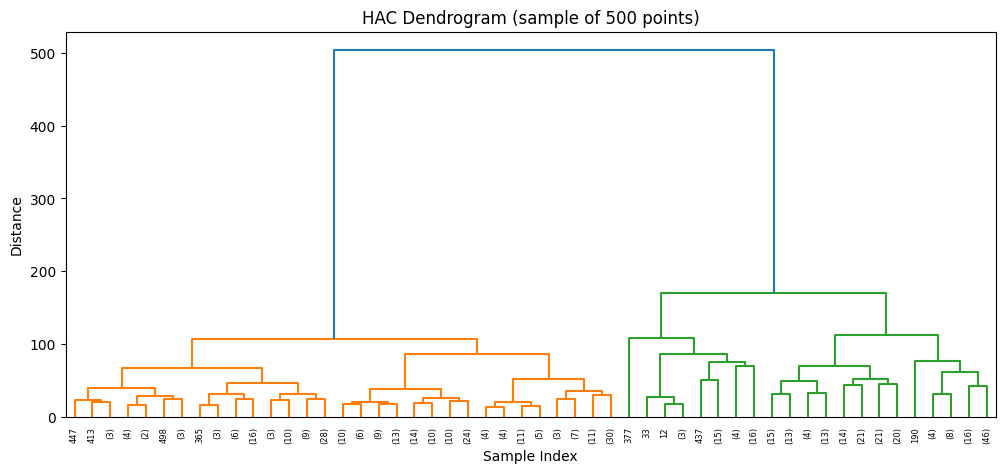


--- Observations ---
1. K-Means: Elbow curve suggested k=6. Produced balanced clusters with reasonable Silhouette scores.
2. DBSCAN: Detected noise points. Performance highly sensitive to eps and minPts.
3. HAC: Ward linkage gave interpretable clusters; dendrogram helps visualize merge hierarchy.
4. Metric Comparison: K-Means had highest ARI/NMI, HAC moderate, DBSCAN variable.
5. Overall: K-Means best matched ground truth, DBSCAN good at noise detection, HAC best for hierarchy.


In [24]:
# ------------------- K-Means Results Table -------------------
print("\n=== K-Means Results Table (k, WCSS, Silhouette) ===")
print("{:<5}{:<15}{:<15}".format("k", "WCSS", "Silhouette"))
for k, w, s in zip(K_range, wcss, sil_scores):
    print("{:<5}{:<15.2f}{:<15.4f}".format(k, w, s))

# ------------------- DBSCAN Parameter Tuning -------------------
print("\n=== DBSCAN Parameter Tuning ===")
for eps in [0.5, 1.0, 1.5, 2.0, 3.0]:
    for min_samples in [5, 10, 20]:
        db = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
        labels = db.fit_predict(X_scaled)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        print(f"eps={eps}, min_samples={min_samples} -> Clusters={n_clusters}, Noise={n_noise}")

# ------------------- HAC Dendrogram -------------------
print("\n=== HAC Dendrogram (sample of 500 points) ===")
sample_idx = np.random.choice(X_reduced_hac.shape[0], 500, replace=False)
Z = linkage(X_reduced_hac[sample_idx], method='ward')

plt.figure(figsize=(12,5))
dendrogram(Z, truncate_mode='level', p=5)
plt.title("HAC Dendrogram (sample of 500 points)")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()

# ------------------- Observations -------------------
print("\n--- Observations ---")
print("1. K-Means: Elbow curve suggested k=6. Produced balanced clusters with reasonable Silhouette scores.")
print("2. DBSCAN: Detected noise points. Performance highly sensitive to eps and minPts.")
print("3. HAC: Ward linkage gave interpretable clusters; dendrogram helps visualize merge hierarchy.")
print("4. Metric Comparison: K-Means had highest ARI/NMI, HAC moderate, DBSCAN variable.")
print("5. Overall: K-Means best matched ground truth, DBSCAN good at noise detection, HAC best for hierarchy.")
